<a href="https://colab.research.google.com/github/AgarwalMayank2/Face_Detection/blob/main/applying_ML_algorithms/Clustering_PRMLproj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task : Identify Face in image using clustering algorithm
dataset : using processed dataset

we extracted CNN(ResNet), HoG, LBP features and made these processed datasets

processed datasets : https://github.com/AgarwalMayank2/Face_Detection/tree/main/processed_dataset


# Clustering on CNN features

## Loading filtered_CNN_features_dataset

In [45]:
# Importing all necesaary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import accuracy_score, adjusted_rand_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [46]:
# Load Dataset
url_filtered_CNN_features_dataset = 'https://raw.githubusercontent.com/AgarwalMayank2/Face_Detection/refs/heads/main/processed_dataset/filtered_CNN_features_dataset.csv' #for CNN limited
df_CNN = pd.read_csv(url_filtered_CNN_features_dataset) # reading url for extracted CNN_features_dataset_limited.csv
df_CNN.drop('Unnamed: 0', axis=1, inplace=True)

# Keep labels with >= 80 samples
label_counts = df_CNN['2048'].value_counts()
labels_to_keep = label_counts[label_counts >= 80].index
df_CNN = df_CNN[df_CNN['2048'].isin(labels_to_keep)]

Splitting dataframe into train and test in 4:1 ratio

In [47]:
# Separate features and labels
X = df_CNN.iloc[:, :-1]
y = df_CNN.iloc[:, -1]

# Encode labels (alphabetically)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# encoding is benificial as working on numbers is lot easier than working on string

# Ensure stratified split (16 training, 4 testing per class)
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = train_test_split(X, y_encoded, test_size=1/5, random_state=42, stratify=y_encoded)

# Normalize features
scaler = StandardScaler()
X_train_CNN = scaler.fit_transform(X_train_CNN)
X_test_CNN = scaler.transform(X_test_CNN)

# Apply LDA with at most (number of classes - 1) components
lda = LDA(n_components=min(500, len(set(y_train_CNN)) - 1))
lda.fit_transform(X_train_CNN, y_train_CNN)

X_train_CNN = lda.transform(X_train_CNN)
X_test_CNN = lda.transform(X_test_CNN)

print(f"After applying LDA => Training size: {X_train_CNN.shape}, Testing size: {X_test_CNN.shape}")

After applying LDA => Training size: (912, 4), Testing size: (228, 4)


## Function of algorithm

In [48]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None

    def fit_predict(self, X):
        random_indices = random.sample(range(0, X.shape[0]), self.n_clusters)
        self.centroids = X[random_indices]

        for i in range(self.max_iter):
            cluster_group = self.assign_clusters(X)
            old_centroids = self.centroids.copy()
            self.centroids = self.move_centroids(X, cluster_group)
            if np.allclose(old_centroids, self.centroids):
                break
        return cluster_group

    def assign_clusters(self, X):
        cluster_group = []
        for row in X:
            distances = [np.linalg.norm(row - centroid) for centroid in self.centroids]
            cluster_group.append(np.argmin(distances))
        return np.array(cluster_group)

    def move_centroids(self, X, cluster_group):
        new_centroids = []
        for i in range(self.n_clusters):
            cluster_points = X[cluster_group == i]
            if len(cluster_points) > 0:
                new_centroids.append(cluster_points.mean(axis=0))
            else:
                # If a cluster has no points, reinitialize randomly
                new_centroids.append(X[random.randint(0, X.shape[0] - 1)])
        return np.array(new_centroids)

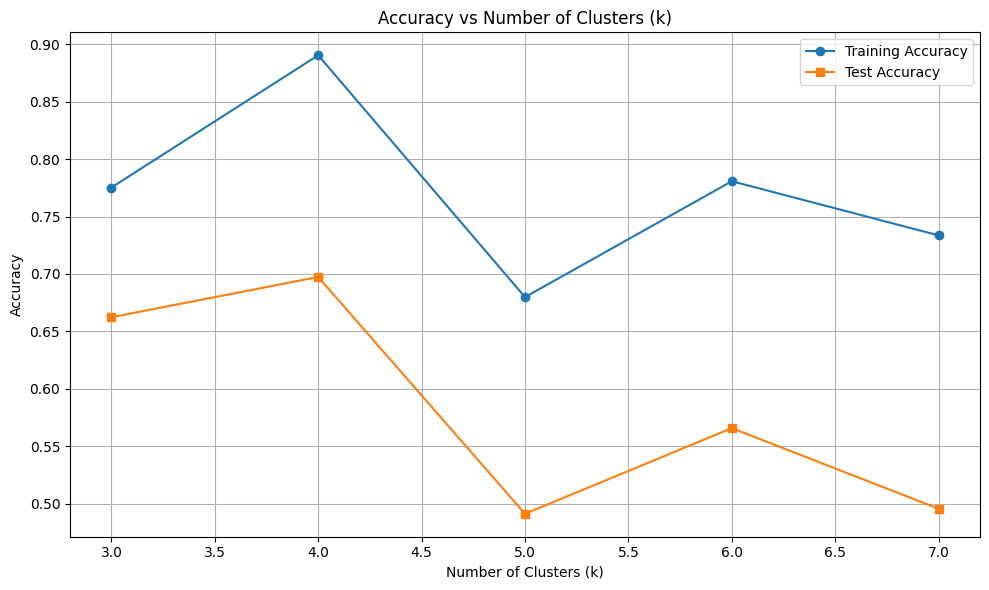

In [49]:
def get_cluster_label_mapping(y_true, cluster_ids):
    conf_mat = confusion_matrix(y_true, cluster_ids)
    row_ind, col_ind = linear_sum_assignment(-conf_mat)
    return dict(zip(col_ind, row_ind))  # cluster_id -> label

# Prediction function
def predict_with_cluster_labels(kmeans_model, X_new, cluster_to_label):
    clusters = kmeans_model.assign_clusters(X_new)
    predicted_labels = np.array([cluster_to_label.get(cluster, -1) for cluster in clusters])
    return predicted_labels

# --- Loop over different values of k ---
true_k = len(np.unique(y_train_CNN))
k_values = [true_k - 2, true_k - 1, true_k, true_k + 1, true_k + 2]

train_accuracies = []
test_accuracies = []

for k in k_values:
    kmeans = CustomKMeans(n_clusters=k, max_iter=100)
    train_clusters = kmeans.fit_predict(X_train_CNN)

    # Try-catch in case of poor clustering
    try:
        cluster_to_label = get_cluster_label_mapping(y_train_CNN, train_clusters)
        y_train_pred = predict_with_cluster_labels(kmeans, X_train_CNN, cluster_to_label)
        y_test_pred = predict_with_cluster_labels(kmeans, X_test_CNN, cluster_to_label)

        train_acc = accuracy_score(y_train_CNN, y_train_pred)
        test_acc = accuracy_score(y_test_CNN, y_test_pred)
    except:
        train_acc = 0
        test_acc = 0

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(k_values, test_accuracies, marker='s', label='Test Accuracy')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Clusters (k)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()